In [26]:
import os
import torch
import torchaudio
import numpy as np

In [27]:
folder="Convolution"
subfolder="mic_signal"

file_path=os.path.join(folder,subfolder)

# wav file 불러오기
file_list=os.listdir(file_path)
file_list.sort()
file_list

['mic1.wav', 'mic2.wav', 'mic3.wav', 'mic4.wav', 'mic5.wav', 'mic6.wav']

### delay and sum beamformer
- time domain

In [28]:
import os
import math
import torch
import torchaudio
import numpy as np

### delay and sum beamformer
# 마이크 신호 load
sample_rate= 48000
mic1,_=torchaudio.load(os.path.join(file_path,file_list[0]))
mic2,_=torchaudio.load(os.path.join(file_path,file_list[1]))
mic3,_=torchaudio.load(os.path.join(file_path,file_list[2]))
mic4,_=torchaudio.load(os.path.join(file_path,file_list[3]))
mic5,_=torchaudio.load(os.path.join(file_path,file_list[4]))
mic6,_=torchaudio.load(os.path.join(file_path,file_list[5]))


# desired signal은 src2
# 소스와 마이크 사이의 시간 지연값
src_angle=60
distance=0.2
speed_of_sound=343
sample_rate=48000
time_delay=distance*math.cos(math.radians(src_angle))/speed_of_sound

# 지연을 적용한 마이크 신호 계산
mic1_delayed=torch.roll(mic1, shifts=int(time_delay*0*sample_rate), dims=1)
mic2_delayed=torch.roll(mic2, shifts=int(time_delay*1*sample_rate), dims=1)
mic3_delayed=torch.roll(mic3, shifts=int(time_delay*2*sample_rate), dims=1)
mic4_delayed=torch.roll(mic4, shifts=int(time_delay*3*sample_rate), dims=1)
mic5_delayed=torch.roll(mic5, shifts=int(time_delay*4*sample_rate), dims=1)
mic6_delayed=torch.roll(mic6, shifts=int(time_delay*5*sample_rate), dims=1)
# mic1[:, time_delay*sample_rate:]
# torch.nn.functional.pad(mic1, (time_delay*sample_rate, 0))

folder4_path="Beamformed"

# 빔포밍 수행
beamformed_signal=(mic1_delayed+mic2_delayed+mic3_delayed+mic4_delayed+mic5_delayed+mic6_delayed)/len(file_list)
# 결과를 wav 파일로 저장
torchaudio.save(os.path.join(folder4_path,'Beamformed.wav'),beamformed_signal,sample_rate)


In [22]:
file_list

['mic1.wav', 'mic2.wav', 'mic3.wav', 'mic4.wav', 'mic5.wav', 'mic6.wav']

### delay and sum beamformer
- frequency domain

In [23]:
import os
import torch
import torchaudio
import numpy as np

In [24]:
folder="Convolution"
subfolder="mic_signal"

file_path=os.path.join(folder,subfolder)

# 마이크 파일
mic_files=os.listdir(file_path)
print(mic_files)
# 소스 파일
desired_file=os.path.join("Original","p225_150_mic1.wav")
print(desired_file)

['mic1.wav', 'mic6.wav', 'mic5.wav', 'mic4.wav', 'mic2.wav', 'mic3.wav']
Original/p225_150_mic1.wav


In [25]:
### torchaudio로 WAV 파일 load
def load_wav_files(mic_files, desired_file):
    mic_signals = []
    # 각 마이크 신호 load
    for file in mic_files:
        signal, rate = torchaudio.load(os.path.join(file_path, file))
        mic_signals.append(signal)
    
    # 원하는 신호 load
    desired_signal, rate_desired = torchaudio.load(desired_file)
    return mic_signals, desired_signal, rate_desired

mic_signals, desired_signal, rate_desired = load_wav_files(mic_files, desired_file)

RuntimeError: Error opening 'Original/p225_150_mic1.wav': System error.

In [ ]:
desired_signal.shape[-1]

217546

In [ ]:
mic_signals[0].shape[-1]

265545

In [ ]:
freq_desired = torch.fft.fft(torch.tensor(desired_signal, dtype=torch.complex64))
freq_desired

/tmp/ipykernel_432500/1452293876.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  freq_desired = torch.fft.fft(torch.tensor(desired_signal, dtype=torch.complex64))


tensor([[2.8002+7.2417e-08j, 2.8791-4.5682e-01j, 2.7026+1.7775e+00j,
          ..., 4.7518+8.5754e-01j, 2.7026-1.7775e+00j,
         2.8791+4.5681e-01j]])

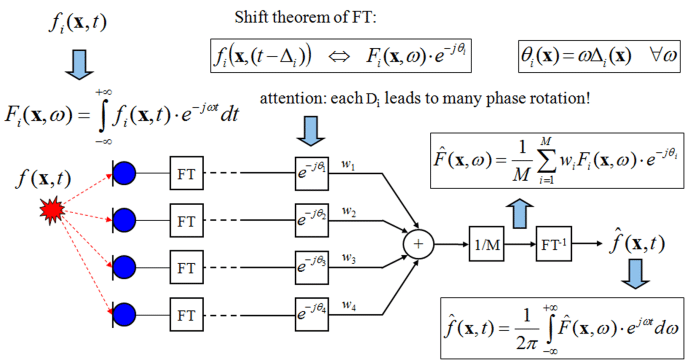

In [ ]:
# Delay and Sum Beamformer 함수
def delay_and_sum_beamformer(mic_signals, desired_signal, sampling_rate):
    num_mics = len(mic_signals)  # 마이크의 수
    num_samples = mic_signals[0].shape[-1]  # 샘플의 수

    # 원하는 신호의 주파수 영역 표현
    freq_desired = torch.fft.fft(torch.tensor(desired_signal, dtype=torch.complex64))

    # 각 주파수에 대한 파장 계산
    frequencies = torch.fft.fftfreq(num_samples, d=1/sampling_rate)
    wavenumbers = 2 * np.pi * frequencies

    # 빔포밍된 신호를 초기화합니다.
    beamformed_signal = torch.zeros(num_samples)

    # 주파수 영역에서 위상 변화 계산/합산
    for i in range(num_mics):
        # 마이크 신호의 주파수 영역 표현
        freq_mic = torch.fft.fft(torch.tensor(mic_signals[i], dtype=torch.complex64))
        
        # 위상 변화를 적용합니다.
        freq_mic_shifted = freq_mic * torch.exp(-1j * wavenumbers)
        
        # 빔포밍된 신호에 추가합니다.
        beamformed_signal += torch.fft.ifft(freq_mic_shifted).real.sum()

    return beamformed_signal.numpy()

# Delay and Sum Beamformer 함수를 호출하여 빔포밍된 신호를 얻습니다.
beamformed_signal = delay_and_sum_beamformer(mic_signals, desired_signal, sample_rate)


# 빔포밍된 신호를 WAV 파일로 저장합니다.
torchaudio.save("Beamformed","room1","beamformed_signal.wav", torch.tensor(beamformed_signal), sample_rate)


/tmp/ipykernel_432500/351922481.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  freq_desired = torch.fft.fft(torch.tensor(desired_signal, dtype=torch.complex64))
/tmp/ipykernel_432500/351922481.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  freq_mic = torch.fft.fft(torch.tensor(mic_signals[i], dtype=torch.complex64))


AttributeError: 'str' object has no attribute 'ndim'